In [583]:
import os
import csv
import numpy as np
import utils
import hrr_utils
import time
import random
import scipy
import sklearn

from __future__ import division
from pylab import *
from scipy import spatial
from scipy.spatial import distance
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})


cwd = os.getcwd()


alph = 'abcdefghijklmnopqrstuvwxyz#.'
N=6000
D = len(alph)
dic1 = letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = letter_vecs2 = 2 * (np.random.randn(D, N) < 0) - 1


def read_verbs(url):
    keys = ['low', 'medium', 'high']
    verbs = {key: [] for key in keys}
    
    with open(url, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        curr_verbs = []
        i = 0
        for row in reader:
            if row[0] in keys:
                curr_verbs = verbs[row[0]]
            else:
                curr_verbs.append([row[0], row[1]])
            i+=1
    return verbs

def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph=alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(verbs)):
        pair = verbs[m]
#         print ('pair', pair)
        PRES1[m] = ngram_encode_cl(pair[0], dic1)
        PRES2[m] = ngram_encode_cl(pair[0], dic2)
        PAST1[m] = ngram_encode_cl(pair[1], dic1)
        PAST2[m] = ngram_encode_cl(pair[1], dic2)
#         print(pair[0], np.sum(PRES1[m]), pair[1], np.sum(PRES2[m]))
    return PRES1, PRES2, PAST1, PAST2

def gen_verb_set(verbs, freq_sizes):
    keys = ['high', 'medium', 'low']
    verb_set_keys = ['dif', 'pres1', 'pres2', 'past1', 'past2']
    size = sum([freq_sizes[freq] for freq in keys])    
    verb_set = {key: np.zeros((size, N)) for key in verb_set_keys}
    unseen_verb_set = {key: np.zeros((size, N)) for key in verb_set_keys}
    i = 0
    verbs_to_encode = []
    unseen_verbs_to_encode = []
    for freq in keys:
        size = freq_sizes[freq]
        indices = list(np.random.choice(len(verbs[freq]), size, replace=False))
        for index in range(len(verbs[freq])):
            if index in indices:
                verbs_to_encode.append(verbs[freq][index])
            else:
                unseen_verbs_to_encode.append(verbs[freq][index])

    verb_set['pres1'], verb_set['pres2'], verb_set['past1'], verb_set['past2'] = genX(verbs_to_encode)
    unseen_verb_set['pres1'], unseen_verb_set['pres2'], unseen_verb_set['past1'], unseen_verb_set['past2'] = genX(unseen_verbs_to_encode)

    return verb_set, verbs_to_encode, unseen_verb_set, unseen_verbs_to_encode

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)



In [ ]:
from __future__ import division

#import random_idx
#import utils
import pickle
import time
import scipy
import scipy.special
import string
from pylab import *
%matplotlib inline

plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

In [584]:
def state_setup(state_length, letter_vecs, N, D, n_steps):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
        
    return states, coef_hists

# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 

        th_vec = bound_vec - bv

    return states, coef_hists


In [639]:
# todo: create training and test set of verb pairs for resonance attractor
irreg_verbs1 = read_verbs('data/cleaned/R&M_irregular.csv')
irreg_verbs2 = read_verbs('data/cleaned/Brown_irregular_std=1.csv')
reg_verbs = read_verbs('data/cleaned/Brown_regular_std=0.25.csv')

irreg_verbs = irreg_verbs1

for freq, tenses in irreg_verbs2.items():
    irreg_verbs[freq] += tenses
    
for k, v in irreg_verbs.items():
    print (k, len(v))
    
comb_verbs = reg_verbs
for freq, tenses in irreg_verbs.items():
    comb_verbs[freq] += tenses

"""
10 high freq
410 med freq
86 low freq

irregular
8 high freq
76 med freq
14 low freq

regular
2 high freq
334 med freq
72 low freq 
"""
# irreg_freqs = {'high': 8, 'medium': 76, 'low': 14}
# reg_freqs = {'high': 2, 'medium': 334, 'low': 72}
# comb_freqs = {'high': 10, 'medium': 410, 'low': 86}

irreg_freqs = {'high': 4, 'medium': 4, 'low': 4}
reg_freqs = {'high': 4, 'medium': 4, 'low': 4}
comb_freqs = {'high': 2, 'medium': 2, 'low': 2}

# create a seen and unseen set
irreg_vecs, irreg_verbs, unseen_irreg_vecs, unseen_irreg_verbs = gen_verb_set(irreg_verbs, irreg_freqs)
reg_vecs, reg_verbs, unseen_reg_vecs, unseen_reg_verbs  = gen_verb_set(reg_verbs, reg_freqs)
comb_vecs, comb_verbs, unseen_comb_vecs, unseen_comb_verbs = gen_verb_set(comb_verbs, comb_freqs)

('high', 8)
('medium', 217)
('low', 49)


In [626]:
def diff_trigram_dict(past2, pres1, pres2, regularized=False):
    psi = np.zeros(N)
    for k in range(past2.shape[0]):
        bound_diff = pres1[k] * (past2[k]-pres2[k])
        if regularized:
            pred = psi*pres1[k] + pres2[k]
            psi += ((N-sim(pred, past2[k]))/float(N)) * bound_diff
        else:
            psi += bound_diff
    return psi

In [587]:
diff_psi_irreg = diff_trigram_dict(irreg_vecs['past2'],
                                   irreg_vecs['pres1'],
                                   irreg_vecs['pres2'])



In [588]:
# predict a word in bound_vec
# unregularized bind
word = irreg_verbs[0][0]
word_length = len(irreg_verbs[0][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * diff_psi_irreg + word_vec2

In [589]:
print irreg_verbs

[['have', 'had'], ['get', 'got'], ['come', 'came'], ['go', 'went'], ['catch', 'caught'], ['choose', 'chose'], ['fake', 'fake row'], ['be', 'was'], ['catch', 'caught'], ['wind', 'wound'], ['clothe', 'clothed'], ['undo', 'undid']]


In [592]:
# predict a word not in bound_vec
# unregularized bind
word = unseen_irreg_verbs[10][0]
word_length = len(unseen_irreg_verbs[10][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * diff_psi_irreg + word_vec2

In [593]:
nsteps=100

states, coef_hists = state_setup(word_length+2, letter_vecs2, N, D, n_steps)
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs2, N, D, n_steps)

('put', 'put')


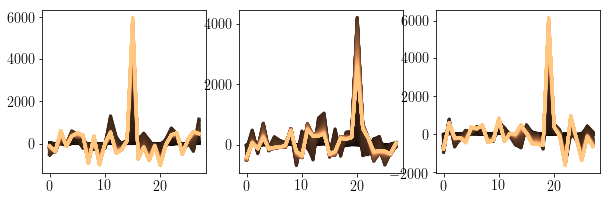

In [594]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(500,n_steps))
for i in range(min(500,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print (word, pred)

In [599]:
regularized_diff_psi_irreg = diff_trigram_dict(irreg_vecs['past2'],
                                               irreg_vecs['pres1'],
                                               irreg_vecs['pres2'],
                                               True
                                              )

In [600]:
# predict a word in bound_vec
# unregularized bind
word = irreg_verbs[0][0]
word_length = len(irreg_verbs[0][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * diff_psi_irreg + word_vec2

In [601]:
# predict a word not in bound_vec
# unregularized bind
word = unseen_irreg_verbs[10][0]
word_length = len(unseen_irreg_verbs[10][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * regularized_diff_psi_irreg + word_vec2

('put', 'put')


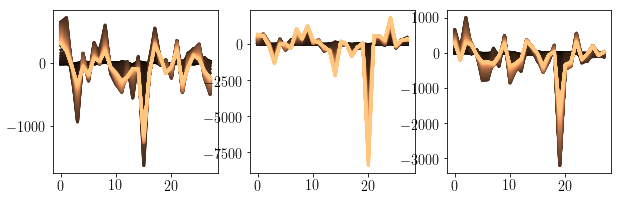

In [602]:
nsteps=100

states, coef_hists = state_setup(word_length+2, letter_vecs2, N, D, n_steps)
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs2, N, D, n_steps)

figure(figsize=(10,3))
cols = get_cmap('copper', min(500,n_steps))
for i in range(min(500,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print (word, pred)

In [644]:
diff_psi_reg = diff_trigram_dict(reg_vecs['past2'],
                                 reg_vecs['pres1'],
                                 reg_vecs['pres2'],
                                )

In [641]:
# predict a word in bound_vec
# unregularized bind
word = reg_verbs[0][0]
word_length = len(reg_verbs[0][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * diff_psi_reg + word_vec2

In [655]:
# predict a word not in bound_vec
# unregularized bind
word = unseen_reg_verbs[0][0]
word_length = len(unseen_reg_verbs[0][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * diff_psi_reg + word_vec2

('make', 'make')


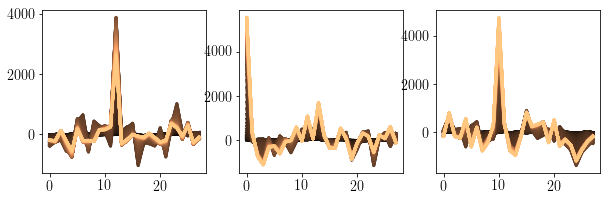

In [656]:
nsteps=100

states, coef_hists = state_setup(word_length+2, letter_vecs2, N, D, n_steps)
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs2, N, D, n_steps)

figure(figsize=(10,3))
cols = get_cmap('copper', min(500,n_steps))
for i in range(min(500,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print (word, pred)

In [712]:
regularized_diff_psi_reg = diff_trigram_dict(reg_vecs['past2'],
                                             reg_vecs['pres1'],
                                             reg_vecs['pres2'],
                                             True
                                            )

In [713]:
print reg_verbs

[['work', 'worked'], ['offer', 'offered'], ['lie', 'lay'], ['escape', 'escaped'], ['hurry', 'hurried'], ['satisfy', 'satisfied'], ['rearrange', 'rearranged'], ['hear', 'heard'], ['counsel', 'counseled'], ['lasso', 'lassoed'], ['reproach', 'reproached'], ['beget', 'begot']]


In [722]:
# predict a word in bound_vec
# unregularized bind
word = reg_verbs[1][0]
word_length = len(reg_verbs[1][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * regularized_diff_psi_reg + word_vec2

In [720]:
# predict a word not in bound_vec
# unregularized bind
word = unseen_reg_verbs[0][0]
word_length = len(unseen_reg_verbs[0][1])
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

pred_vec = word_vec1 * regularized_diff_psi_reg + word_vec2

('offer', 'offered')


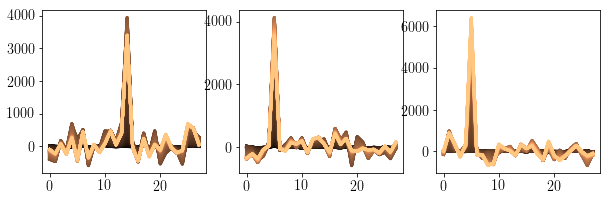

In [723]:
nsteps=150

states, coef_hists = state_setup(word_length+2, letter_vecs2, N, D, n_steps)
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs2, N, D, n_steps)

figure(figsize=(10,3))
cols = get_cmap('copper', min(500,n_steps))
for i in range(min(500,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print (word, pred)

In [733]:
def closed_train(diff, pred):
    return np.dot(np.linalg.pinv(diff), pred)

def cap_closed_train(diff, pred):
    return np.dot(np.linalg.pinv(diff,rcond=5e-2), pred)

def diff_trigram_regress(pres1, past2, pres2, b, cap=False):
    if cap:
        return cap_closed_train(past2-pres2, b*pres1)
    return closed_train(past2-pres2, b*pres1)

In [734]:
W_reg = diff_trigram_regress(reg_vecs['pres1'], reg_vecs['past2'], reg_vecs['pres2'], diff_psi_reg)
# W_irreg = diff_trigram_regress(irreg_vecs['pres1'], irreg_vecs['past2'], irreg_vecs['pres2'])
# cap_W_reg = diff_trigram_regress(reg_vecs['pres1'], reg_vecs['past2'], reg_vecs['pres2'], True)
# cap_W_irreg = diff_trigram_regress(irreg_vecs['pres1'], irreg_vecs['past2'], irreg_vecs['pres2'], True)
# W = diff_trigram_regress(comb_vecs['pres1'], comb_vecs['past2'], comb_vecs['pres2'])
# cap_W = diff_trigram_regress(comb_vecs['pres1'], comb_vecs['past2'], comb_vecs['pres2'], True)

['give', 'gave']
give


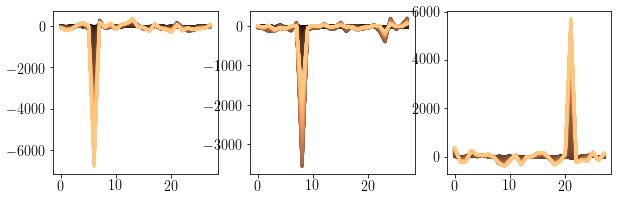

In [736]:
def predict(word, word_length, pred_vec, pair, W, nsteps=100):
    states, coef_hists = state_setup(word_length+2, letter_vecs2, N, D, n_steps)
    states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs2, N, D, n_steps)

    figure(figsize=(10,3))
    cols = get_cmap('copper', min(500,n_steps))
    for i in range(min(500,n_steps)):
        subplot(131)
        plot(coef_hists[0][i,:], lw=3, c=cols(i))
        subplot(132)
        plot(coef_hists[1][i,:], lw=3, c=cols(i))
        subplot(133)
        plot(coef_hists[2][i,:], lw=3, c=cols(i))

    pred = ''
    for i in range(len(coef_hists)):
        pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

    print pred

def demo(pair, unseen_pair, W, nsteps=100):
    # predict a word in bound_vec
#     word = pair[0]
#     word_length = len(pair[1])
#     word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
#     word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

#     pred_vec = word_vec1.dot(W) + word_vec2
#     predict(pair[1], word_length, pred_vec, pair, W, nsteps)
    
    # predict a word not in bound_vec
    print unseen_pair
    word = unseen_pair[0]
    word_length = len(unseen_pair[1])
    word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)
    word_vec2 = ngram_encode_cl(word, letter_vecs2, alph)

    pred_vec = word_vec1.dot(W) + word_vec2
    predict(unseen_pair[1], word_length, pred_vec, unseen_pair, W, nsteps)
    
    
# demo(reg_verbs[0], unseen_reg_verbs[6], W_reg)
demo(irreg_verbs[0], unseen_irreg_verbs[1], W_irreg)
